# Evaluate para Random Forest (Modelo seleccionado)
Se seleccionó este modelo por sus resultados en la evaluación preliminar dentro de MLFlow, este notebook esta hecho para expandir la evaluación del mismo con mas metricas relevantes y determinar su impacto en el negocio.
## Cargado de modelo y librerias pertinentes

In [18]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix,
    roc_curve, precision_recall_curve, auc,
    average_precision_score, accuracy_score
)

X_test = pd.read_csv("datos/procesados/X_test.csv")
m = joblib.load("models/rf_pipeline.joblib")
y_test = pd.read_csv("datos/procesados/y_test.csv").squeeze()
y_pred = m.predict(X_test)
y_prob = m.predict_proba(X_test)[:, 1]
X_train = pd.read_csv("datos/procesados/X_train.csv")
y_train = pd.read_csv("datos/procesados/y_train.csv").squeeze()



## Métricas de clasificación estándar

In [2]:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
area_under_curve = roc_auc_score(y_test, y_prob)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {area_under_curve:.4f}")


Precision: 0.9780
Recall: 0.9771
F1 Score: 0.9775
AUC-ROC: 0.9981


Las métricas muestran un desempeño muy alto en todos los frentes: el modelo acierta casi siempre, recupera casi todos los casos que debe detectar y mantiene un equilibrio sólido entre precisión y recall. El AUC confirma que separa muy bien las clases. Con valores tan cercanos al límite superior, es razonable asumir que el modelo está capturando patrones de forma demasiado ajustada al conjunto con el que fue evaluado. No invalida el resultado, pero sí indica que el rendimiento real fuera de este entorno probablemente sería más bajo.

## Matriz de confusión


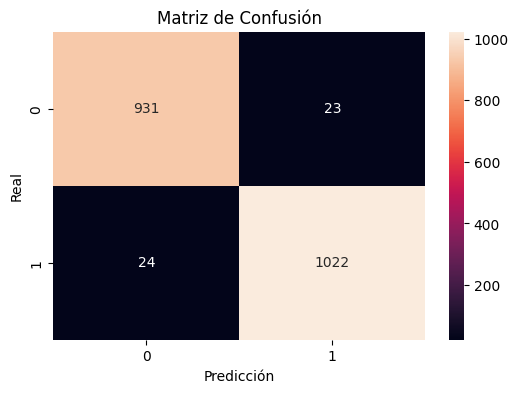

In [3]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()


El comportamiento es equilibrado: el modelo casi no deja pasar falsos como verdaderos (solo 23 FP) y tampoco deja muchos verdaderos sin detectar (24 FN). Los bloques dominantes son TN y TP, lo que indica que el modelo distingue bien entre falso y verdadero sin sesgarse hacia una clase. El nivel de error es bajo y simétrico, lo que hace que la separación entre clases sea consistente y refleja el mismo patrón de alto desempeño que muestran las demás métricas.

## Curvas ROC y Precision-Recall

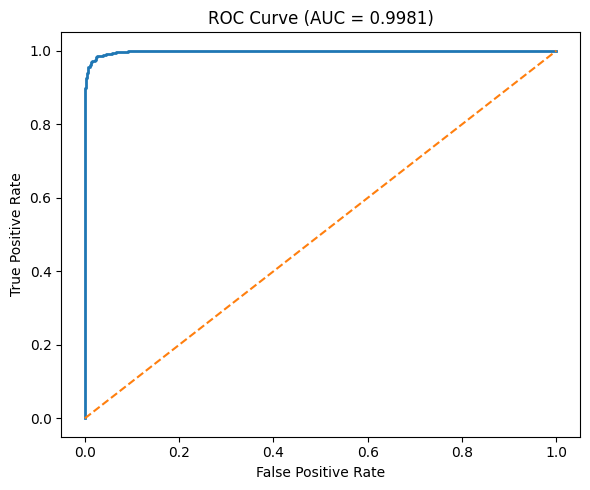

In [6]:
y_prob = m.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve (AUC = {roc_auc:.4f})")
plt.tight_layout()
plt.show()

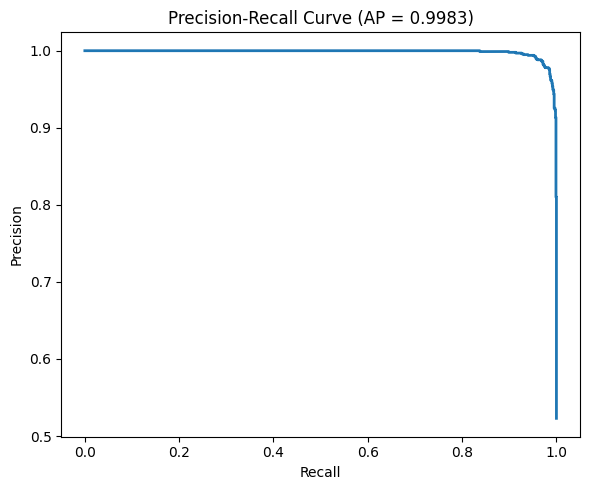

In [8]:
precision, recall, _ = precision_recall_curve(y_test, y_prob)
ap = average_precision_score(y_test, y_prob)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, linewidth=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision-Recall Curve (AP = {ap:.4f})")
plt.tight_layout()
plt.show()


## Feature importance y interpretabilidad del modelo

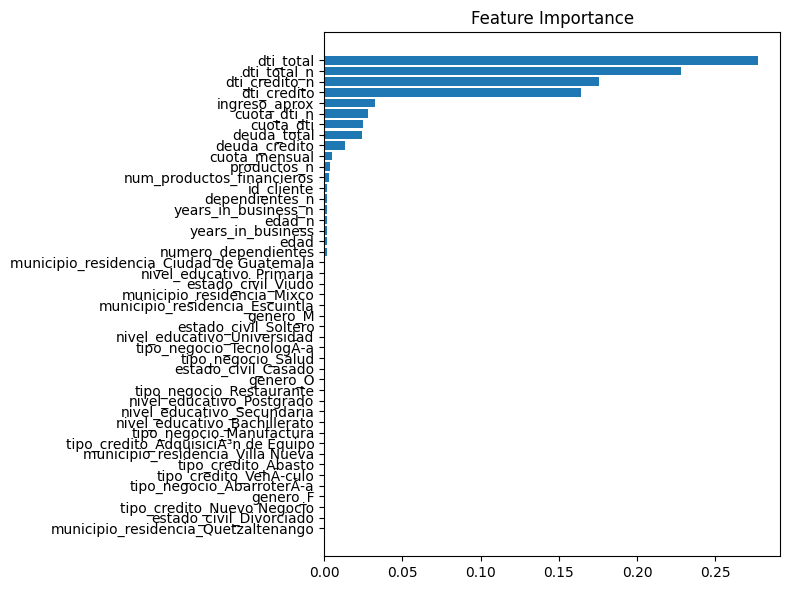

In [11]:


rf = m.named_steps["rf"] 
importances = rf.feature_importances_

cols = X_test.columns
df_imp = pd.DataFrame({"feature": cols, "importance": importances})
df_imp = df_imp.sort_values("importance", ascending=False)

plt.figure(figsize=(8, 6))
plt.barh(df_imp["feature"], df_imp["importance"])
plt.gca().invert_yaxis()
plt.title("Feature Importance")
plt.tight_layout()
plt.show()


Podemos ver que el feature mas importante es el radio de deuda-ingresos total, lo cual hace sentido al tomar en cuenta la problematica analizada y la variable respuesta.

In [14]:
y_pred = m.predict(X_test)

acc = accuracy_score(y_test, y_pred)
baseline = max(y_test.mean(), 1 - y_test.mean())

print("Accuracy:", acc)
print("Baseline:", baseline)


Accuracy: 0.9765
Baseline: 0.523


El resultado indica que el modelo tiene una alta capacidad para predecir correctamente qué clientes incumplirán pagos: con un accuracy de 97.65%, clasifica correctamente casi todos los casos, muy por encima del baseline de 52.3%, que sería lo que se lograría sin un modelo inteligente (por ejemplo, prediciendo siempre que los clientes pagarán).

## Validación Cruzada Temporal

In [19]:
tscv = TimeSeriesSplit(n_splits=5)

scores = cross_val_score(
    m,
    X_train,
    y_train,
    cv=tscv,
    scoring="f1"
)

scores


array([0.97956307, 0.97843866, 0.97821187, 0.97081851, 0.98730606])

El array muestra la accuracy del modelo en distintas particiones temporales, con valores muy altos entre 97% y 98.7%. Esto indica que el modelo **mantiene un desempeño consistente y robusto a lo largo del tiempo**, logrando predecir de manera confiable los incumplimientos de pago en diferentes periodos. Para la empresa, significa que puede **anticipar riesgos de morosidad de forma estable**, lo que permitiría tomar medidas preventivas y reducir las pérdidas por capital e intereses asociados a la cartera en mora.

## Analisis de Errores y Casos Edge

In [ ]:
errors = pd.DataFrame({
    "y_true": y_test,
    "y_pred": y_pred,
    "prob": y_prob
})
errors[errors["y_true"] != errors["y_pred"]]


,y_true,y_pred,prob
6,0,1,0.538843
13,1,0,0.296285
83,0,1,0.591222
159,0,1,0.762177
184,0,1,0.742321
189,1,0,0.486745
201,1,0,0.118839
226,1,0,0.298837
239,1,0,0.437592
277,1,0,0.300494


En conjunto, el análisis de errores sugiere que, aunque el modelo es muy preciso en general, hay casos de riesgo no detectado y falsas alarmas, principalmente en situaciones ambiguas, lo que puede orientar ajustes en el umbral de decisión o estrategias de mitigación de riesgo específicas.
## Evaluación de impacto en el negocio esperado

In [ ]:
# Supuestos de negocio
perdida_moroso = 1300 
costo_accion_preventiva = 50  

# Referencia de los supuestos:
# Pérdida promedio por cliente moroso y costo de acción preventiva basados en:
# Federal Reserve Board (2020). "The Cost Structure of Consumer Finance Companies and Its Implications for Interest Rates".
# https://www.federalreserve.gov/econres/notes/feds-notes/the-cost-structure-of-consumer-finance-companies-and-its-implications-for-interest-rates-20200812.html

# Falsos negativos: clientes morosos no detectados
falsos_negativos = errors[(errors['y_true']==1) & (errors['y_pred']==0)]

# Falsos positivos: clientes correctos marcados como riesgo
falsos_positivos = errors[(errors['y_true']==0) & (errors['y_pred']==1)]

# Impacto económico
ahorro_potencial = len(falsos_negativos) * perdida_moroso
costo_preventivo = len(falsos_positivos) * costo_accion_preventiva
impacto_neto = ahorro_potencial - costo_preventivo

# Resultados
print("Falsos Negativos:", len(falsos_negativos))
print("Falsos Positivos:", len(falsos_positivos))
print("Ahorro potencial por prevenir morosidad: Q", ahorro_potencial)
print("Costo de acciones preventivas: Q", costo_preventivo)
print("Impacto neto estimado: Q", impacto_neto)

Falsos Negativos: 24
Falsos Positivos: 23
Ahorro potencial por prevenir morosidad: Q 31200
Costo de acciones preventivas: Q 1150
Impacto neto estimado: Q 30050


Podemos ver que el impacto estimado es alto por lo que suponemos que el modelo tendra un impacto positivo en el negocio evitando que las personas dejen de pagar sus prestamos.